## Magnet optimization

In [1]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import cvxpy as cp
import pickle, random

In [2]:
# Libraries for visualization
from matplotlib import rc
import matplotlib.pyplot as plt
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=True)
import magpylib as magpy
import seaborn as sns

In [3]:
Br = 1.43 # (T) Residual flux density for N42
mu_0 = 4 * np.pi * 10**-7 # (H/m) Permeability of free space
l = 2.54e-2 # (m) Length of cube magnet
Volume = l ** 3 # (m^3)
moment = Br * Volume / mu_0 # (A m^2)
j = Br / mu_0 # (A/m)

In [4]:
Volume = 3.0e-3 ** 3
moment_target = Br * Volume / mu_0

In [5]:
target = np.array([0.2, 0.2, 0.55]) # target position is at 40 cm above the origin
workspace_length = 0.4 # workspace is a cube of 20 cm side length
mt = np.array([moment_target, 0, 0])

In [6]:
# return the magnetic field generated by a magnet at position p and orientation r
def generate_random_pose() -> tuple[np.ndarray, np.ndarray]:
    # generate a random pose
    r = R.random()
    p = np.random.rand(3) * workspace_length
    return p, r.as_matrix()

In [7]:
def B(p_i: np.ndarray, dm_i: np.ndarray):
  r_i = target - p_i
  r_i_hat = r_i / np.linalg.norm(r_i)
  return mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 3) * ((3 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) @ dm_i)

def F(p_i: np.ndarray, dm_i: np.ndarray):
  r_i = target - p_i
  r_i_hat = r_i / np.linalg.norm(r_i)
  return 3 * mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 4) \
    * np.dot(
      np.outer(dm_i, r_i_hat) + 
      np.outer(r_i_hat, dm_i) - 
      ((5 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) * np.dot(dm_i, r_i_hat))
      , mt)

def Jb(p_i: np.ndarray, dm_i: np.ndarray):
  r_i = target - p_i
  r_i_hat = r_i / np.linalg.norm(r_i)
  return mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 3) * ((3 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) @ dm_i)

def Jf(p_i: np.ndarray, dm_i: np.ndarray):
  r_i = target - p_i
  r_i_hat = r_i / np.linalg.norm(r_i)
  return 3 * mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 4) \
    * np.dot(
      np.outer(dm_i, r_i_hat) + 
      np.outer(r_i_hat, dm_i) - 
      ((5 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) * np.dot(dm_i, r_i_hat))
      , mt)

In [69]:
m = 100 # Number of random poses
K = 8 # Selection budget
d = 2 # Number of divisions for angles
n = d ** K

In [9]:
# Generating all combinations of angles
lins  = [np.linspace(0, 1.5*np.pi, d) for i in range(K)]
# lins.append(np.linspace(0, 2*np.pi, d) + np.pi/4)
angles = np.array(np.meshgrid(*lins)).T.reshape(-1, K)

In [70]:
# S is an array of tuples, each tuple contains a position and a rotation matrix
S = [generate_random_pose() for i in range(m)]

In [11]:
def calculate_max():
  global Bmax, Fmax
  Bs = []
  Fs = []
  for p, r in S:
    m_i = np.array([0, 0, moment]) # all magnets having north pole facing upwards
    Bs.append(np.linalg.norm(B(p, m_i)))
    Fs.append(np.linalg.norm(F(p, m_i)))

  Bmax = np.partition(Bs, -K)[-K:].sum() # Sum of the norms of K highest fields
  Fmax = np.partition(Fs, -K)[-K:].sum() # Sum of the norms of K highest forces

In [12]:
calculate_max()
print(Bmax, Fmax)

4.0638962714587965 1.1858509576505583


In [13]:
# Create subsets of overlapping magnets
def overlapping(S):
  overlapping = []
  for i in range(len(S)):
    for j in range(i+1, len(S)):
      if np.linalg.norm(S[i][0] - S[j][0]) < 1.5 * l:
        overlapping.append([i, j])
  return overlapping


In [14]:
# Initizaling A
def init_A():
  global A
  A = np.zeros((n, K, m, 6, 6))
  calculate_max()

  for t, theta in enumerate(angles):
    for i in range(K):
      for j, (p, r) in enumerate(S):
        dmagnetization = r.dot([- np.sin(theta[i]), np.cos(theta[i]), 0])
        J = np.concatenate([Jb(p, dmagnetization)/Bmax, Jf(p, dmagnetization)/Fmax]) 
        A[t, i, j, :, :] = np.outer(J, J)

In [15]:
# # Initizaling f
# f = np.zeros((n, K, m, 6, 6))

# for t, theta in enumerate(angles):
#   for i in range(K):
#     for j, (p, r) in enumerate(S):
#       magnetization = r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
#       fj = np.concatenate([B(p, magnetization)/Bmax, F(p, magnetization)/Fmax])
#       f[t, i, j, :, :] = np.outer(fj, fj)

In [71]:
init_A()

In [17]:
def A_operator(X, t):
  return cp.sum([X[i][j] * A[t, i, j] for i in range(K) for j in range(m)])

def f_operator(X):
  return cp.sum([X[i][j] * f[t, i, j] for t in range(n) for i in range(K) for j in range(m)])

### CVXPY Setup

In [18]:
def init_problem():
  global X, t, prob
  X = cp.Variable(shape=(K, m))
  t = cp.Variable(1)

  alpha = 0.1
  # obj = cp.Maximize(t + alpha * cp.atoms.lambda_min(f_operator(X)))
  obj = cp.Maximize(t)
  cons1 = X >= 0.0
  cons2 = X <= 1.0
  cons4 = cp.sum(X) == K # sum of all elements is K
  cons5 = cp.sum(X, axis=1) == 1.0 # sum of each row is 1
  cons6 = cp.sum(X, axis=0) <= 1.0 # sum of each col is le 1
  cons7 = t >= 0.0
  constraints = [cons1, cons2, cons5, cons6]
  for i in range(n):
    constraints.append(t <= cp.atoms.lambda_min(A_operator(X, i)))
  # for o in overlapping(S):
  #   constraints.append(cp.sum([X[i][j] for i in range(K) for j in o]) <= 0.8)
  prob = cp.Problem(obj, constraints)

In [72]:
init_problem()

In [73]:
def solve_problem():
  global X, t, prob
  prob.solve(solver=cp.CLARABEL)
  # tol = 1.0e-5
  # prob.solve(verbose=False, solver=cp.CLARABEL, tol_gap_abs=tol, tol_gap_rel=tol, tol_feas=tol)

In [74]:
solve_problem()

c:\Users\Veerash\MiniConda3\envs\magnetics\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [25]:
print("Status: ", prob.status)
# print("Solution x = ", X.value)
print("Solution t = ", t.value)

Status:  optimal_inaccurate
Solution t =  [1.03268341e-08]


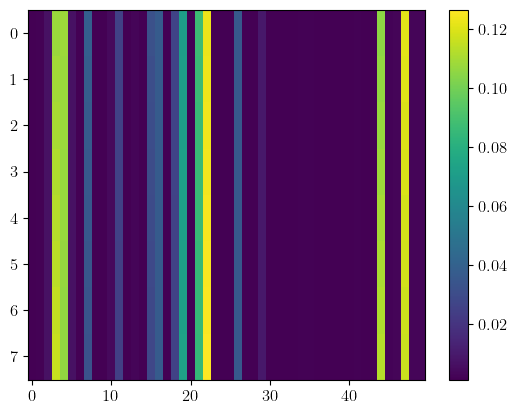

In [45]:
# make it wider
c = plt.imshow(X.value, aspect="auto", )
plt.colorbar(c)
plt.show()

## Rounding

In [21]:
def top_k(soln, k):
  result = cp.sum(soln, axis=0)
  return np.argsort(result.value)[-k:]

In [47]:
inds = top_k(X, K)
print(inds)

[16 19 21  4 44  3 47 22]


In [ ]:
aaaa = [1, 2, 3]
print(aaaa[-0])

In [22]:
def top_k_no_overlap(soln, k):
  result = cp.sum(soln, axis=0)
  sorted = np.argsort(result.value)
  # greedily pick the top k magnets that do not overlap
  selected = []
  selected.append(sorted[-1])
  #loop bakwards
  for i in range(2, len(sorted) + 1):
    if len(selected) == k:
      break
    passes = True
    for j in selected:
      if np.linalg.norm(S[sorted[-i]][0] - S[j][0]) < 1.5 * l:
        passes = False
        break
    if passes:
      selected.append(sorted[-i])
  return selected

In [812]:
inds = top_k_no_overlap(X, K)

In [ ]:
inds

## Saving and Loading data

In [ ]:
dp = dict(S=S, X=X, t=t, params={"m": m, "K": K, "d": d, "n": n, "target": target, "Bmax": Bmax, "Fmax": Fmax})

with open("runs/c100k8_01.pkl", "wb") as cp_file:
    pickle.dump(dp, cp_file)

In [ ]:
def load_data(filename):
  dp = pickle.load(open(filename, "rb"))
  
  global X, S, t, m, K, d, n, Bmax, Fmax, inds
  
  X, S, t = dp["X"], dp["S"], dp["t"]
  m, K, d, n = dp["params"]["m"], dp["params"]["K"], dp["params"]["d"], dp["params"]["n"]
  # Bmax, Fmax = dp["params"]["Bmax"], dp["params"]["Fmax"]
  calculate_max()
  inds = top_k_no_overlap(X, K)

In [16]:
load_data("runs/c1000_07_2.pkl")

## Histogram of singular values

In [25]:
def calculate_singular_values_rounded(inds):
  singular_values = []
  for theta in angles:
    J = np.zeros((K, 6))
    for i, ind in enumerate(inds):
      p, r = S[ind]
      dmagnetization = r.dot([-np.sin(theta[i]), np.cos(theta[i]), 0])
      Ji = np.concatenate([Jb(p, dmagnetization)/Bmax, Jf(p, dmagnetization)/Fmax])
      J[i] = Ji
    s = np.linalg.svd(J, compute_uv=False)
    singular_values.append(min(s))
  return singular_values
	  

In [ ]:
print(len(angles))

In [ ]:
calculate_max()
Bmax, Fmax

In [124]:
load_data("runs/c1000_07_2.pkl")
singular_values_1000 = calculate_singular_values_rounded(inds)

In [123]:
load_data("runs/c500_07_2.pkl")
singular_values_500 = calculate_singular_values_rounded(inds)

In [122]:
load_data("runs/c300_07_2.pkl")
singular_values_300 = calculate_singular_values_rounded(inds)

In [119]:
load_data("runs/c100_07_2.pkl")
singular_values_100 = calculate_singular_values_rounded(inds)

In [85]:
load_random()
singular_values_random = calculate_singular_values_rounded(inds)

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(3.5, 5))

# axes[0].hist(singular_values_random, bins=30, color="indianred", edgecolor="black", linewidth=0.5, zorder=3)
binwidth = 0.000005
histocolor = "indianred"
histolinewidth = 0.0005


bin100 = np.arange(min(singular_values_100), max(singular_values_100) + binwidth, binwidth)
axes[0].hist(singular_values_100, bins=bin100, color=histocolor, edgecolor="black", linewidth=histolinewidth, zorder=3)

bin300 = np.arange(min(singular_values_300), max(singular_values_300) + binwidth, binwidth)
axes[1].hist(singular_values_300, bins=bin300, color=histocolor, edgecolor="black", linewidth=histolinewidth, zorder=3)

# bin500 = np.arange(min(singular_values_500), max(singular_values_500) + binwidth, binwidth)
# axes[2].hist(singular_values_500, bins=bin500, color="indianred", edgecolor="black", linewidth=0.5, zorder=3)

bin1000 = np.arange(min(singular_values_1000), max(singular_values_1000) + binwidth, binwidth)
axes[2].hist(singular_values_1000, bins=bin1000, color=histocolor, edgecolor="black", linewidth=histolinewidth, zorder=3)

for ax in axes:
  ax.grid(True, alpha=0.5, zorder=0)
  # ax.ticklabel_format(axis='x', scilimits=[-3, 3])
  # ax.set_xscale("log")
  ax.set_ylim(0, 20)
  ax.set_xlim(0, 0.0006)
  # ax.set_xlim(0.000001, 0.001)
  ax.locator_params(axis='x', nbins=3)
  ax.locator_params(axis='y', nbins=3)
  ax.set_xlabel("Singular Value")
  # ax.set_xlabel('''test
  #               test''')
  ax.set_ylabel("Count")
  # ax.set_font("Computer Modern")
axes[0].set_title(r'\textbf{(a) M=100}')
axes[1].set_title(r'\textbf{(b) M=300}')
axes[2].set_title(r'\textbf{(c) M=1000}')
# plt.subplots_adjust(hspace = 0.3)
# plt.show()
fig.tight_layout()
plt.savefig('m_comparison.eps', format='eps')

In [ ]:
inds = np.random.randint(0, m, K)
singular_values_random = []
for theta in angles:
  J = np.zeros((K, 6))
  for i, ind in enumerate(inds):
    p, r = S[ind]
    dmagnetization = r.dot([-np.sin(theta[i]), np.cos(theta[i]), 0])
    Ji = np.concatenate([Jb(p, dmagnetization)/Bmax, Jf(p, dmagnetization)/Fmax])
    J[i] = Ji
  _, x, _ = sp.svds(J, k=1, which='SM')
  singular_values_random.append(x[0])

## Histogram of unrounded solution

In [67]:
def calculate_singular_values_relaxed():
  singular_values = []

  for i in range(n):
    singular_values.append(cp.atoms.lambda_min(A_operator(X, i)).value)
  return singular_values

In [ ]:
min(singular_values)

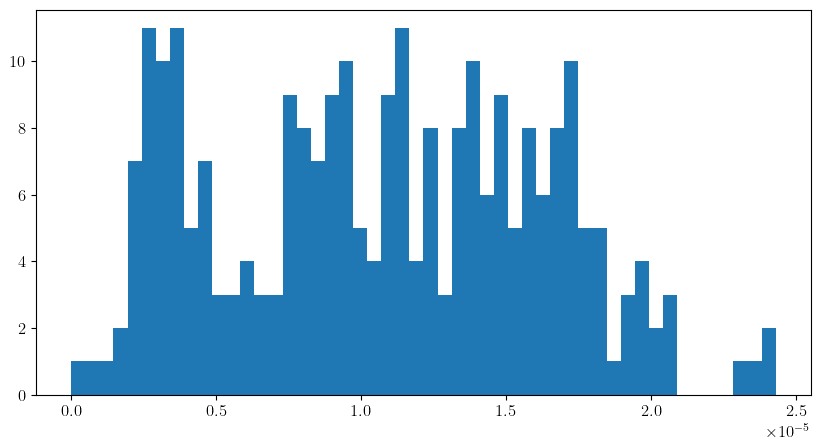

In [68]:
plt.hist(singular_values, bins=50)
plt.gcf().set_size_inches(10, 5)
plt.plot([t.value, t.value], [0,50], ls="-")
plt.show()

## Greedy

In [28]:
g_angles = np.linspace(0, 1.5*np.pi, d)


In [35]:
def greedy_cost(j):
  lambda_mins = []
  for ang in g_angles:
    p, r = S[j]
    dm = r.dot([- np.sin(ang), np.cos(ang), 0])
    J = np.concatenate([Jb(p, dm)/Bmax, Jf(p, dm)/Fmax])
    lambda_mins.append(np.linalg.svd(np.outer(J, J), compute_uv=False)[0])
  return min(lambda_mins)
  

In [65]:
def get_greedy_inds():
  all_cost = np.array([greedy_cost(j) for j in range(m)])
  return np.argsort(all_cost)[-K:]
  

In [75]:
inds = top_k(X, K)
inds

array([60, 72, 57, 26, 71, 39, 75, 44], dtype=int64)

In [76]:
singular_values_greedy = singular_values

In [77]:
singular_values = calculate_singular_values_rounded(inds)

In [ ]:
singular_values = calculate_singular_values_rounded(inds)
singular_values_greedy = calculate_singular_values_rounded(get_greedy_inds())

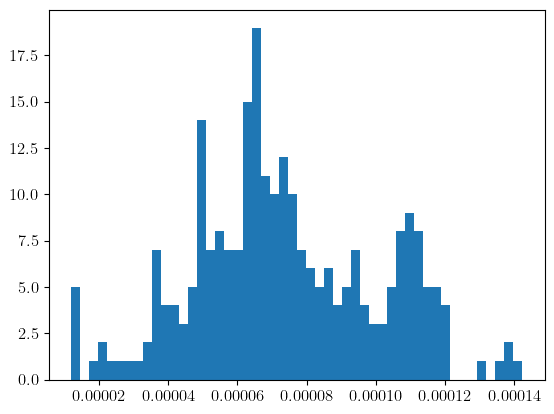

In [56]:
plt.hist(singular_values, bins=50)
plt.show()

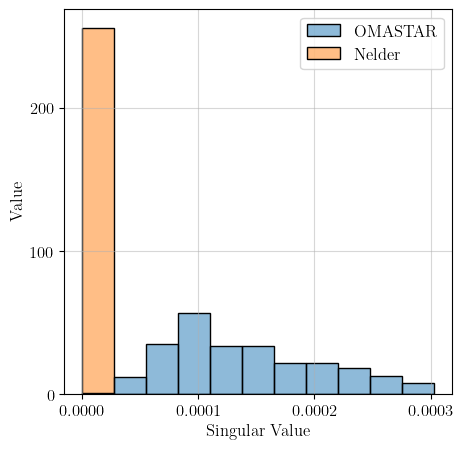

In [79]:
fig = plt.figure(figsize=(5, 5))
my_pal = {"0": "goldenrod", "K=6": "cornflowerblue", "Brute Force":"gray", "K=8":"indianred"}
ax = sns.histplot({"OMASTAR": singular_values, "Nelder": singular_values_greedy})
ax.set(xlabel='Singular Value', ylabel='Value')
ax.grid(True, alpha=0.5, zorder=0)
ax.locator_params(axis='x', nbins=4)
ax.locator_params(axis='y', nbins=3)
#change font color on labels
ax.set_xlabel(ax.get_xlabel(), color="black")
ax.set_ylabel(ax.get_ylabel(), color="black")
# plt.show()
# ax.set_rasterized(True)
# plt.savefig('k6k8.eps', format='eps')
plt.savefig("k6k8.pdf",bbox_inches='tight')
# plt.savefig('k6k8.png', format='png')

In [59]:
num_trials = 3

In [60]:
import pandas as pd

In [ ]:
df = pd.DataFrame(columns=["Relaxed", "Greedy", "OMASTAR"])


In [65]:
df = pickle.load(open("runs/greedy_100_11.pkl", "rb"))

In [76]:
for i in range(num_trials):
  S = [generate_random_pose() for i in range(m)]
  init_A()
  init_problem()
  solve_problem()
  # print(t.value)
  inds = top_k(X, K)
  sv_rounded = calculate_singular_values_rounded(inds)
  sv_greedy = calculate_singular_values_rounded(get_greedy_inds())
  # sv_bruteforce = calculate_singular_values_rounded(brutefroce_inds)
 
  # sv_random = calculate_singular_values_rounded(np.random.randint(0, m, K))
  df.loc[i, "OMASTAR"] = min(sv_rounded)
  # df.loc[i, "Relaxed"] = np.sqrt(min(calculate_singular_values_relaxed()))
  df.loc[i, "Greedy"] = min(sv_greedy)

c:\Users\Veerash\MiniConda3\envs\magnetics\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\Veerash\MiniConda3\envs\magnetics\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\Veerash\MiniConda3\envs\magnetics\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [66]:
df.shape

(30, 3)

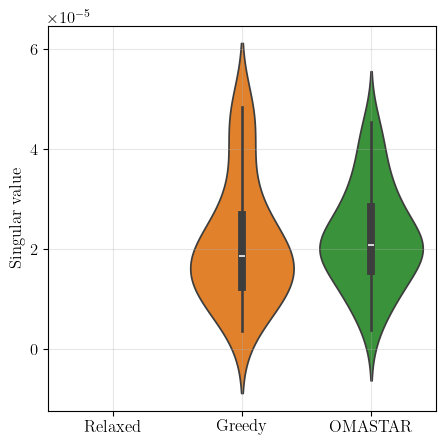

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(df)
plt.ylabel("Singular value")
plt.grid(True, alpha=0.3, zorder=0)
plt.ticklabel_format(axis='y', scilimits=[-3, 3])
plt.locator_params(axis='y', nbins=6)
plt.show()

## Bruteforce

In [ ]:
from itertools import combinations
m_list = list(range(m))
com = list(combinations(m_list, K))
def get_bruteforce_inds():
  ts = []
  for inds in com:
    singular_values = []
    for ang in angles:
      J = np.zeros((K, 6))
      for i, ind in enumerate(inds):
        p, r = S[ind]
        dm = r.dot([- np.sin(ang[i]), np.cos(ang[i]), 0])
        J[i] = np.concatenate([Jb(p, dm)/Bmax, Jf(p, dm)/Fmax])
      s = np.linalg.svd(J, compute_uv=False)
      singular_values.append(min(s))
  ts.append(min(singular_values))
  return com[np.argmax(ts)]
    

## Symmetric

In [ ]:
# a symmetric setup of magnets
S = [
  ([0.3, 0, 0], R.random().as_matrix()),
  ([-0.3, 0, 0], R.random().as_matrix()),
  ([0, 0.3, 0], R.random().as_matrix()),
  ([0, -0.3, 0], R.random().as_matrix()),
  ([0.15, 0.15, 0], R.random().as_matrix()),
  ([0.15, -0.15, 0], R.random().as_matrix()),
  ([-0.15, 0.15, 0], R.random().as_matrix()),
  ([-0.15, -0.15, 0], R.random().as_matrix()),
]

In [ ]:
# a symmetric setup of magnets
def load_symmetric():
  global S, inds
  S = [
    ([0.3 + 0.05, 0.15 + 0.05, 0.35], R.from_euler('xyz', [0, -135, 0], degrees=True).as_matrix()),
    ([0 + 0.05, 0.15 + 0.05, 0.35], R.from_euler('xyz', [0, -135, 180], degrees=True).as_matrix()),
    ([0.15 + 0.05, 0.3 + 0.05, 0.35], R.from_euler('xyz', [0, -135, 90], degrees=True).as_matrix()),
    ([0.15 + 0.05, 0 + 0.05, 0.35], R.from_euler('xyz', [0, -135, -90], degrees=True).as_matrix()),
    ([0.225 + 0.05, 0.225 + 0.05, 0.35], R.from_euler('xyz', [0, -135, 45], degrees=True).as_matrix()),
    ([0.225 + 0.05, 0.075 + 0.05, 0.35], R.from_euler('xyz', [0, -135, -45], degrees=True).as_matrix()),
    ([0.075 + 0.05, 0.225 + 0.05, 0.35], R.from_euler('xyz', [0, -135, 135], degrees=True).as_matrix()),
    ([0.075 + 0.05, 0.075 + 0.05, 0.35], R.from_euler('xyz', [0, -135, -135], degrees=True).as_matrix()),
  ]
  calculate_max()
  inds = list(range(8))

## Random

In [ ]:
def load_random(num_magnet=8):
  global S, inds
  S = [generate_random_pose() for i in range(num_magnet)]
  calculate_max()
  inds = list(range(num_magnet))

In [ ]:
coll = magpy.Collection()

j = Br / mu_0 

for i in range(len(S)):
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)).rotate_from_angax(np.linspace(0, 90, 30), axis=r.dot([0, 0, 1]), start=0))
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))

magpy.show(coll, animation=True)

## Nelder Mead

Approach: 

For each combination of angles, find the normalized jacobian for k number of magnets then its smallest singular value. The smallest singular value over all angles is the cost function.

In [55]:
def cost(x):
  global num_magnets
  singular_values = []
  for theta in angles:
    J = np.zeros((num_magnets, 6))
    for i in range(num_magnets-1):
      p, r = S[i]
      dmagnetization = r.dot([-np.sin(theta[i]), np.cos(theta[i]), 0])
      Ji = np.concatenate([Jb(p, dmagnetization)/Bmax, Jf(p, dmagnetization)/Fmax])
      J[i] = Ji
      
    p = x[:3]
    r = R.from_euler("zyx", x[3:]).as_matrix()
    dmagnetization = r.dot([-np.sin(theta[num_magnets-1]), np.cos(theta[num_magnets-1]), 0])
    J[num_magnets-1] = np.concatenate([Jb(p, dmagnetization)/Bmax, Jf(p, dmagnetization)/Fmax])
    
    s = np.linalg.svd(J, compute_uv=False)
    singular_values.append(min(s))
  return min(singular_values)

In [48]:
a = [(0, workspace_length)]
b = [*[(0, workspace_length)]*3,None, None, None]
b

[(0, 0.4), (0, 0.4), (0, 0.4), None, None, None]

In [30]:
from scipy.optimize import minimize

In [63]:
S = [generate_random_pose()]
num_magnets = 1

for i in range(2, 9):
  num_magnets = i
  pr, rr = generate_random_pose()
  x0 = [*pr, *(R.from_matrix(rr).as_euler("zyx"))]
  res = minimize(cost, x0, method='Nelder-Mead', bounds=[*[(0, workspace_length)]*3, (None,None), (None,None), (None,None)], options={'maxiter': 2000})
  if(not res.success):
    print("Error finding optimal", res.message)
  S.append((res.x[:3], R.from_euler("zyx", res.x[3:]).as_matrix()))


In [ ]:
singular_values = calculate_singular_values_rounded(list(range(num_magnets)))

In [67]:
len(singular_values)

256

In [ ]:

res = minimize(cost, x0, method='Nelder-Mead', bounds=[*[(0, workspace_length)]*3,None, None, None], options={'gtol': 1e-13, 'disp': False, 'maxiter': 1000, })

## Evaluation

In [ ]:
from scipy.optimize import minimize

In [ ]:
def force_x(x):
  total_force_x = 0.
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([np.cos(x[i]), np.sin(x[i]), 0])
    total_force_x += np.abs(F(p, m_i)[0])
    # What to do for jac abs
  return -1. * total_force_x

def force_x_grad(x):
  jac = np.array([])
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([-np.sin(x[i]), np.cos(x[i]), 0])
    jac = np.append(abs(jac), Jf(p, m_i)[1])
  return jac
    

In [ ]:
x0 = np.random.rand(K) * 2*np.pi
print(x0)
bounds = [(0, 2 * np.pi)] * K
res = minimize(force_x, x0, method='CG', jac=force_x_grad,
               options={'gtol': 1e-6, 'disp': True})

In [ ]:
print(res.x)

### Comparison of K

In [ ]:
with open("runs/k6k8.pkl", "rb") as cp_file:
  cp = pickle.load(cp_file)
  sv_roundedk6  = cp["sv_k6"]
  sv_roundedk8 = cp["sv_k8"]

In [ ]:
fig = plt.figure(figsize=(3.5, 2))
my_pal = {"0": "goldenrod", "K=6": "cornflowerblue", "Brute Force":"gray", "K=8":"indianred"}
ax = sns.histplot({"K=6": sv_roundedk6, "K=8": sv_roundedk8}, stat='percent', common_norm=False, palette=my_pal)
ax.set(xlabel='Singular Value', ylabel='Percent')
ax.grid(True, alpha=0.5, zorder=0)
ax.locator_params(axis='x', nbins=4)
ax.locator_params(axis='y', nbins=3)
#change font color on labels
ax.set_xlabel(ax.get_xlabel(), color="black")
ax.set_ylabel(ax.get_ylabel(), color="black")
# plt.show()
# ax.set_rasterized(True)
# plt.savefig('k6k8.eps', format='eps')
plt.savefig("k6k8.pdf",bbox_inches='tight')
# plt.savefig('k6k8.png', format='png')

### Boxplot min singular value

In [ ]:
num_trials = 10
K = 6
m = 10

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(columns=["Relaxed", "Rounded", "Brute Force", "Random"])

In [ ]:
import pickle

In [ ]:
with open("runs/box_df_2rm15k8.pkl", "rb") as cp_file:
    df = pickle.load(cp_file)

In [ ]:
with open("runs/box_df_k8m15.pkl", "rb") as cp_file:
    df = pickle.load(cp_file)

In [ ]:
with open("runs/box_df_k6m10_fixed_1.pkl", "rb") as cp_file:
    df = pickle.load(cp_file)

In [ ]:
with open("runs/box_df_k6m10_fixed_1.pkl", "rb") as cp_file:
    df = pickle.load(cp_file)

In [ ]:
for i in range(num_trials):
  S = [generate_random_pose() for i in range(m)]
  init_A()
  init_problem()
  solve_problem()
  # print(t.value)
  inds = top_k(X, K)
  sv_rounded = calculate_singular_values_rounded(inds)
  brutefroce_inds = get_bruteforce_inds()
  sv_bruteforce = calculate_singular_values_rounded(brutefroce_inds)
 
  sv_random = calculate_singular_values_rounded(np.random.randint(0, m, K))
  df.loc[i, "Rounded"] = min(sv_rounded)
  df.loc[i, "Relaxed"] = np.sqrt(min(calculate_singular_values_relaxed()))
  df.loc[i, "Brute Force"] = min(sv_bruteforce)
  df.loc[i, "Random"] = min(sv_random)
  

In [ ]:
# import seaborn as sns
# sns.set_theme(font_scale=1.0)
# sns.set_style()
fig, ax = plt.subplots(figsize=(3.5, 2))
# sns.set_theme(style="ticks", palette="deep")
my_pal = {"Relaxed": "goldenrod", "Rounded": "cornflowerblue", "Brute Force":"lightgray", "Random":"indianred"}
sns.violinplot(df, palette=my_pal, zorder=2)
# plt.yscale("log")
plt.ylabel("Singular value")
plt.grid(True, alpha=0.3, zorder=0)
plt.ticklabel_format(axis='y', scilimits=[-3, 3])
# ax.ticklabel_format(axis='x', scilimits=[-3, 3])
# plt.set_ylim(0, 30)
# plt.set_xlim(0, 0.00025)
plt.locator_params(axis='y', nbins=6)
# plt.title("Minimum σ_min for M=10, K=6")
# plt.show()
plt.savefig('k8m15.eps', format='eps')

In [ ]:
for col in df.columns:
  print(col)
  print("Min", f"{np.min(df[col]):.2E}")
  print("Max", f"{np.max(df[col]):.2E}")
  print("Median", f"{np.median(df[col]):.2E}")
  print("std", f"{np.std(df[col]):.2E}")
  print(" ")

## Diagram of chosen

In [ ]:
inds = top_k_no_overlap(X, K)

In [ ]:
for i in inds:
  print("new Vector3(%ff, %ff, %ff)," % (S[i][0][0], S[i][0][2], S[i][0][1]))

In [ ]:
rs = [R.from_matrix(S[i][1]) for i in inds]
# convert rs to quaternions with y and z axis swapped
quats = [r.as_quat() for r in rs]
quats = np.array([[q[0], q[1], q[2], q[3]] for q in quats])
print("{")
for q in quats:
  print("new Quaternion(%ff, %ff, %ff, %ff)," % (q[0], q[1], q[2], q[3]))
print("}")


In [ ]:
coll = magpy.Collection()

for ind, i in enumerate(inds):
  p, r = S[i]
  # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
  coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)).rotate_from_angax(0, axis=r.dot([0, 0, 1]), degrees=False))#.rotate_from_angax(0, axis=r.dot([0, 0, 1]), degrees=False)
# coll[0].orientation = R.from_quat([0, 0, 0.5, 0.5])

magpy.show(coll, animation=True)

In [ ]:
coll.getB([0.2, 0.2, 0.55])

In [ ]:
# Get x, y, z components of the S
x = [s[0] - 0.2 for s, _ in S]
y = [s[1]- 0.2 for s, _ in S]
z = [s[2]- 0.2 for s, _ in S] 

inds = top_k(X, K)

xc = [S[i][0][0]- 0.2 for i in inds]
yc = [S[i][0][1]- 0.2 for i in inds]
zc = [S[i][0][2]- 0.2 for i in inds] 

In [ ]:
#print position into latex format
for i in inds:
  p, r = S[i]
  rg = r.dot([0, 0, 1])
  print("%.1f & %.1f & %.1f & [%.3f, %.3f, %.3f] \\\\" % (p[0]*100, p[1]*100, p[2]*100, rg[0], rg[1], rg[2]))
  print("\\hline")

In [ ]:
plt.clf()

In [ ]:
coll = magpy.Collection()
j = Br / mu_0

def getColl(angles):
  global coll
  coll = magpy.Collection()
  for ind, i in enumerate(inds):
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(l, l, l), position=p-0.2, orientation=R.from_matrix(r)).rotate_from_angax(angles[ind], axis=r.dot([0, 0, 1]), degrees=False))


In [ ]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, projection='3d')

ax1.scatter(x, y, z, alpha=0.2, color='cornflowerblue', marker='o', facecolors='cornflowerblue', label="Sampled Space")
ax1.scatter(xc, yc, zc, alpha=1, color='indianred', label="Optimal")

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='z', nbins=5)

ax1.legend()

# def animate(frame):
#   ax1.view_init(35, 45 + frame)
  
# ani = animation.FuncAnimation(fig, animate, repeat=True, frames=360, interval=25)

# writer = animation.PillowWriter(fps=15,
#                                 metadata=dict(artist='Me'),
#                                 bitrate=1800)
# ani.save('rotate.gif', writer=writer)

# fig.tight_layout()
# plt.show()
# plt.savefig('optimal2.pdf', bbox_inches='tight')

In [ ]:
getColl(inds)
fig = magpy.show(coll, animation=False, return_fig=True)
fig.write_image("test111.png")

In [ ]:
plt.show()

## Control

In [ ]:
from scipy.optimize import minimize

In [ ]:
calculate_max()

In [ ]:
Kc = np.sqrt(Bmax)/(np.sqrt(Fmax) + np.sqrt(Bmax))
# Kc = 0.5

In [ ]:
Kc

In [ ]:
Kc = 1.0

In [ ]:
def force(x):
  total_force = np.zeros(3)
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([np.cos(x[i]), np.sin(x[i]), 0])
    total_force += F(p, m_i)
  return total_force

def force_jac(x):
  total_force = np.zeros((3, K))
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([-np.sin(x[i]), np.cos(x[i]), 0])
    total_force[:, i] = Jf(p, m_i)
  return total_force

def force_jac2(x):
  total_force = np.zeros(3)
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([-np.sin(x[i]), np.cos(x[i]), 0])
    total_force += Jf(p, m_i)
  return total_force

def field(x):
  total_field = np.zeros(3)
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([np.cos(x[i]), np.sin(x[i]), 0])
    total_field += B(p, m_i)
  return total_field

def field_jac(x):
  total_field = np.zeros((3, K))
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([-np.sin(x[i]), np.cos(x[i]), 0])
    total_field[:, i] = Jb(p, m_i)
  return total_field

def field_jac2(x):
  total_field = np.zeros(3)
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([-np.sin(x[i]), np.cos(x[i]), 0])
    total_field  += Jb(p, m_i)
  return total_field

B0 = field(np.zeros(K))
F0 = force(np.zeros(K))

print("Force: ", field(np.zeros(K)))
print("Field: ", field_jac(np.zeros(K)))
field_jac2(np.zeros(K))

In [ ]:
def control_f(x):
  return (1.0-Kc) * (np.linalg.norm(force(x) - F0)) ** 2 + Kc * (np.linalg.norm(field(x) - B0)) ** 2
def control_f_jac(x):
  return 2.0 * (1.0-Kc) * (force(x) - F0) @ force_jac(x) + 2.0 * Kc * (field(x) - B0) @  field_jac(x)

In [ ]:
rr = np.random.rand(K) * 2*np.pi
print(control_f(rr))
control_f(rr)

In [ ]:
# Max force
def control_f(x):
  return -1 * ((1.0-Kc) * np.linalg.norm(force(x)) ** 2 - Kc * (np.linalg.norm(field(x) - B0)) ** 2)
def control_f_jac(x):
  return -1 * (2.0 * (1.0-Kc) * (force(x)) @ force_jac(x) - 2.0 * Kc * (field(x) - B0) @  field_jac(x))

In [ ]:
# Max field
def control_f(x):
  return -1 * (-1 * (1.0-Kc) * np.linalg.norm(force(x) - F0) ** 2 + Kc * (np.linalg.norm(field(x))) ** 2)
def control_f_jac(x):
  return -1 * (-2.0 * (1.0-Kc) * (force(x)-F0) @ force_jac(x) + 2.0 * Kc * (field(x)) @  field_jac(x))

In [ ]:
# Max field
def control_f(x):
  return -1 * (-1 * (1.0-Kc) * np.linalg.norm(force(x) - F0) ** 2 + Kc * (np.linalg.norm(field(x))) ** 2)
def control_f_jac(x):
  return -1 * (-2.0 * (1.0-Kc) * (force(x)-F0) @ force_jac(x) + 2.0 * Kc * (field(x)) @  field_jac(x))

In [ ]:
mt = np.array([0, moment_target, 0])

In [ ]:
# F0 = np.array([ 0.0,  0.0, 0.001])
# B0 = np.array([ 0.0,  0.0, 0.001])
# F0 = np.array([ 0.0,  0.01, 0.0])
# B0 = np.array([ 0.0,  0.0001, 0.0])
# F0 = np.array([ 0.001, 0.0, 0.0])
B0 = np.array([ 0.01, 0.0, 0.0])
F0 = np.array([ 0.0, 0.0, 0.0])

x0 = np.random.rand(K) * 2*np.pi
print(x0)
print(force(x0))
res = minimize(control_f, x0, method='BFGS', jac=control_f_jac,
               options={'gtol': 1e-13, 'disp': True, 'maxiter': 1000, })

In [ ]:
target = np.array([0.2, 0.2, 1.9-0.55])

In [ ]:
def inverseKinematics():
  res = minimize(control_f, x0, method='BFGS', jac=control_f_jac,
               options={'gtol': 1e-13, 'disp': False, 'maxiter': 1000, })
  return res.x

In [ ]:
print((B0 - field(res.x)))
print(force(res.x) - F0)
print("field: ", field(res.x))
print("force: ", force(res.x))

In [ ]:
B0 = np.array([ 0.0, -0.012, 0.0])
F0 = np.array([ 0.0, 0.0, 0.0])

angles = inverseKinematics()
print("field: ", field(angles))
print("force: ", force(angles), "magnitude: ", np.linalg.norm(force(angles)))
getColl(angles)

print("Field at target: ", coll.getB(target))

In [ ]:
magpy.show(coll, animation=True)

In [ ]:
for a in angles:
    print("%ff" % (a), end=", ")

In [ ]:
load_data("runs/c1000_07_2.pkl")

In [ ]:
import magpylib as magpy
from numpy.linalg import norm
import matplotlib.colors

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["cornflowerblue", "lightgray", "indianred"])

In [ ]:
coll = magpy.Collection()
j = Br / mu_0

def getColl(angles):
  global coll
  coll = magpy.Collection()
  for ind, i in enumerate(inds):
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)).rotate_from_angax(angles[ind], axis=r.dot([0, 0, 1]), degrees=False))


In [ ]:
xrange = 0.05
zmax = target[2] + xrange
zmin = target[2] - xrange
ymax = target[1] + xrange
ymin = target[1] - xrange
xmax = ymax
xmin = ymin
xrange2 = 0.03
numpoints = 100

gridxy = np.array([[(x, y, target[2]) for x in np.linspace(xmin, xmax, numpoints)] for y in np.linspace(ymin, ymax, numpoints)])
x_xy, y_xy, _ = np.moveaxis(gridxy, 2, 0)

gridxz = np.array([[(x, target[1], z) for x in np.linspace(xmin, xmax, numpoints)] for z in np.linspace(zmin, zmax, numpoints)])
x_xz, _, z_xz = np.moveaxis(gridxz, 2, 0)

gridyz = np.array([[(target[0], y, z) for y in np.linspace(ymin, ymax, numpoints)] for z in np.linspace(zmin, zmax, numpoints)])
_, y_yz, z_yz = np.moveaxis(gridyz, 2, 0)


In [ ]:
Kc = 1.0

In [ ]:
Kc = np.sqrt(Bmax)/(np.sqrt(Fmax) + np.sqrt(Bmax))

In [ ]:
plt.clf()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(8, 4))
normb = matplotlib.colors.Normalize(vmin=9, vmax=25)
# Kc = 0.9
B0 = np.array([ 0.012, 0.0, 0.0])
mt = np.array([moment_target, 0, 0])
angles = inverseKinematics()
getColl(angles)

print("Field at target: ", coll.getB(target))

b_xy = coll.getB(gridxy)
Bx_xy, By_xy, _ = np.moveaxis(b_xy, 2, 0)

b_xz = coll.getB(gridxz)
Bx_xz, By_xz, Bz_xz = np.moveaxis(b_xz, 2, 0)

b_yz = coll.getB(gridyz)
Bx_yz, By_yz, Bz_yz = np.moveaxis(b_yz, 2, 0)

splt0 = axes[0][0].streamplot((x_xy-0.2)*100, (y_xy-0.2)*100, Bx_xy, By_xy, color=1000*(norm(b_xy, axis=2)), cmap=cmap, norm=normb, density=0.6)
axes[0][0].plot(0, 0, 'o', color = 'black')

splt2 = axes[1][0].streamplot((x_xz-0.2)*100, (z_xz-0.55)*100, Bx_xz, Bz_xz, color=1000*(norm(b_xz, axis=2)), cmap=cmap, norm=normb, density=0.6)
axes[1][0].plot(0, 0, 'o', color = 'black')

#testing norm
# splt1 = axes[1][0].streamplot((x_xy-0.2)*100, (y_xy-0.2)*100, Bx_xy, By_xy, color=1000*(norm(b_xy, axis=2)), cmap=cmap, density=0.6)
# axes[1][0].plot(0, 0, 'o', color = 'black')

################################################

# mt = np.array([0, moment_target, 0])
B0 = np.array([ 0.0, 0.012, 0.0])
angles = inverseKinematics()
getColl(angles)

print("Field at target: ", coll.getB(target))

b_xy = coll.getB(gridxy)
Bx_xy, By_xy, _ = np.moveaxis(b_xy, 2, 0)

b_xz = coll.getB(gridxz)
Bx_xz, By_xz, Bz_xz = np.moveaxis(b_xz, 2, 0)

b_yz = coll.getB(gridyz)
Bx_yz, By_yz, Bz_yz = np.moveaxis(b_yz, 2, 0)

splt = axes[0][1].streamplot((x_xy-0.2)*100, (y_xy-0.2)*100, Bx_xy, By_xy, color=1000*(norm(b_xy, axis=2)), cmap=cmap, norm=normb, density=0.6)
axes[0][1].plot(0, 0, 'o', color = 'black')

splt2 = axes[1][1].streamplot((y_yz-0.2)*100, (z_yz-0.55)*100, By_yz, Bz_yz, color=1000*(norm(b_yz, axis=2)), cmap=cmap, norm=normb, density=0.6)
axes[1][1].plot(0, 0, 'o', color = 'black')

################################################

mt = np.array([0, 0, moment_target])
B0 = np.array([ 0.0, 0.0, 0.012])
angles = inverseKinematics()
getColl(angles)

print("Field at target: ", coll.getB(target))

b_xy = coll.getB(gridxy)
Bx_xy, By_xy, _ = np.moveaxis(b_xy, 2, 0)

b_xz = coll.getB(gridxz)
Bx_xz, By_xz, Bz_xz = np.moveaxis(b_xz, 2, 0)

b_yz = coll.getB(gridyz)
Bx_yz, By_yz, Bz_yz = np.moveaxis(b_yz, 2, 0)


splt = axes[0][2].streamplot((x_xz-0.2)*100, (z_xz-0.55)*100, Bx_xz, Bz_xz, color=1000*(norm(b_xz, axis=2)), cmap=cmap, norm=normb, density=0.6)
axes[0][2].plot(0, 0, 'o', color = 'black')

splt2 = axes[1][2].streamplot((y_yz-0.2)*100, (z_yz-0.55)*100, By_yz, Bz_yz, color=1000*(norm(b_yz, axis=2)), cmap=cmap, norm=normb, density=0.6)
axes[1][2].plot(0, 0, 'o', color = 'black')



# fig.colorbar(splt0.lines, ax=axes[0][0], label="B (mT)")
# fig.colorbar(splt.lines, ax=axes[0][1], label="B (mT)")
# fig.colorbar(splt.lines, ax=axes[0][2], label="B (mT)")
# fig.colorbar(splt1.lines, ax=axes[1][0], label="B (mT)")
# fig.colorbar(splt.lines, ax=axes[1][1], label="B (mT)")
# fig.colorbar(splt.lines, ax=axes[1][2], label="B (mT)")

for axr in axes:
  for ax in axr:
    ax.set(
        xlabel="x-position (cm)",
        ylabel="z-position (cm)",
        # yticks=[-1, -0.5, 0, 0.5, 1],
        xlim=(-xrange*100, xrange*100),
        ylim=(-xrange*100, xrange*100),
    )

axes[0][0].set_xlabel("x-position (cm)")
axes[0][0].set_ylabel("y-position (cm)")
axes[1][0].set_xlabel("x-position (cm)")
axes[1][0].set_ylabel("z-position (cm)")

axes[0][1].set_xlabel("x-position (cm)")
axes[0][1].set_ylabel("y-position (cm)")
axes[1][1].set_xlabel("y-position (cm)")
axes[1][1].set_ylabel("z-position (cm)")

axes[0][2].set_xlabel("x-position (cm)")
axes[0][2].set_ylabel("z-position (cm)")
axes[1][2].set_xlabel("y-position (cm)")
axes[1][2].set_ylabel("z-position (cm)")

axes[0][0].set_title(r'$\textbf{[12, 0, 0]}$ \textbf{mT}', x= 0.45, pad=20)
axes[0][1].set_title(r'$\textbf{[0, 12, 0]}$ \textbf{mT}', x= 0.45, pad=20)
axes[0][2].set_title(r'$\textbf{[0, 0, 12]}$ \textbf{mT}', x= 0.45, pad=20)
fig.tight_layout()
plt.subplots_adjust(right = 1.1)
fig.colorbar(splt2.lines, ax=axes.ravel().tolist(), label="B (mT)")


fig.patches.extend([plt.Rectangle((0.015, 0), 0.295, 1,
                                  fill=True, color='lightgray', alpha=0.2, zorder=-1,
                                  transform=fig.transFigure, figure=fig)])

fig.patches.extend([plt.Rectangle((0.605, 0), 0.295, 1,
                                  fill=True, color='lightgray', alpha=0.2, zorder=-1,
                                  transform=fig.transFigure, figure=fig)])

# from matplotlib import lines
# line1 = lines.Line2D([0.31,0.31], [0.0,1.0], color='lightgray', lw = 1, transform=fig.transFigure)
# line2 = lines.Line2D([0.605,0.605], [0.0,1.0], color='lightgray', lw = 1, transform=fig.transFigure)
# fig.lines.append(line1)
# fig.lines.append(line2)
# axes[1][0].set(
#     xlabel="y-position (cm)",
#     ylabel="z-position (cm)",
#     # yticks=[-1, -0.5, 0, 0.5, 1],
#     xlim=(-xrange*100, xrange*100),
#     ylim=(-xrange*100, xrange*100),
# )
# plt.subplots_adjust(right = 1.0)
# fig.tight_layout()
# plt.show()
plt.savefig('field_isotropy2.pdf', bbox_inches='tight')
# plt.savefig('field_isotropy.eps', format='eps', bbox_inches='tight')

In [ ]:
norm(b2, axis=2)

In [ ]:
np.shape(axes)

In [ ]:
# magpy.show(coll, animation=False)
plt.show()

In [ ]:
plt.show()

In [ ]:
BF0 = [
  ([ 0.0001,  0.0, 0.0], [ 0.001,  0.0, 0.0]), 
  ([ 0.0,  0.0001, 0.0], [ 0.0,  0.001, 0.0]), 
  ([ 0.0,  0.0, 0.0001], [ 0.0,  0.0, 0.001]),
  ([ 0.0,  0.0001, 0.0001], [ 0.0,  0.001, 0.001])
  ]

In [ ]:
res.x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [ ]:
results = []
results.append(res.x)

In [ ]:
results = []
for i in BF0:
  B0, F0 = i[0], i[1] 
  x0 = np.random.rand(K) * 2*np.pi
  res = minimize(control_f, x0, method='BFGS', jac=control_f_jac,
                options={'gtol': 1e-12, 'maxiter': 1000})
  print(res.success)
  results.append(res.x)

In [ ]:
import magpylib as magpy
from numpy.linalg import norm

In [ ]:

coll = magpy.Collection()
j = Br / mu_0 
inds = top_k(X, K)

# Create an observer grid in the xy-symmetry plane
grid = np.mgrid[0.1:0.2:50j, 0.1:0.2:50j, 0.45:0.45:1j].T[0]
X, Y, _ = np.moveaxis(grid, 2, 0)

# Create an observer grid in the yz-symmetry plane
grid2 = np.array([[(0.15, y, z) for y in np.linspace(0.1, 0.2, 50)] for z in np.linspace(0.4, 0.5, 50)])
_, Y2, Z2 = np.moveaxis(grid2, 2, 0)

for ind, i in enumerate(inds):
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    angles = [r[ind] for r in results]
    coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)).rotate_from_angax(angles, axis=r.dot([0, 0, 1]), start=0, degrees=False))
# for m in coll:
    # m.rotate_from_angax(0, axis=r.dot([0, 0, 1]), start=0, degrees=False))

moments = [[0, 0, 90], [0, -90, 0], [0, -45, 45]]
# dip = magpy.misc.Dipole(moment=BF0[0][1], position=[0, 0, 0.4])
# coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(3.0e-3, 3.0e-3, 3.0e-3), position=target, style_magnetization_mode='arrow'))
coll.add(magpy.misc.Dipole(moment=(j, 0, 0), position=target, style_color='red', style_size=1.5))
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))

print(coll.getB([0.15, 0.15, 0.45]))
b = coll.getB(grid)
Bx, By, _ = np.moveaxis(b, 2, 0)

b2 = coll.getB(grid2)
_, By2, Bz2 = np.moveaxis(b2, 2, 0)

fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.streamplot(X, Y, Bx, By, color=np.log(norm(b, axis=2)), cmap="spring_r")
ax1.plot(0.15, 0.15, 'bo')
ax2.streamplot(Y2, Z2, By2, Bz2, color=np.log(norm(b2, axis=2)), cmap="spring_r")
ax2.plot(0.15, 0.45, 'bo')

ax1.set(
    xlabel="x-position (m)",
    ylabel="y-position (m)",
    xlim=(0.1, 0.2),
    ylim=(0.1, 0.2),
)

ax2.set(
    xlabel="y-position (m)",
    ylabel="z-position (m)",
    xlim=(0.1, 0.2),
    ylim=(0.4, 0.5),
)
magpy.show(coll, animation=False)


In [ ]:
coll = magpy.Collection()

inds = top_k(X, K)

for ind, i in enumerate(inds):
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    angles = [r[ind] for r in results]
    coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)).rotate_from_angax(angles, axis=r.dot([0, 0, 1]), start=0, degrees=False))

moments = [[0, 0, 90], [0, -90, 0], [0, -45, 45]]
# dip = magpy.misc.Dipole(moment=BF0[0][1], position=[0, 0, 0.4])
coll.add(magpy.misc.Dipole(moment=BF0[0][1], position=target, style_color='red', style_size=3.5).rotate_from_euler(moments, "xyz"))
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))

magpy.show(coll, animation=True)


In [ ]:
for ind, i in enumerate(BF0):
  print(i)
  print("B0: ", i[0])
  print("F0: ", i[1])
  print("Error in field", field(results[ind])  - i[0])
  print("Error in Force", force(results[ind]) - i[1])
  print()

## Downstream Testing

In [ ]:
from scipy.stats import uniform_direction

random_directions = uniform_direction.rvs(3, 50)


In [ ]:
with open("runs/random_directions.pkl", "wb") as cp_file:
    pickle.dump(random_directions, cp_file)

In [ ]:
with open("runs/random_directions.pkl", "rb") as cp_file:
    random_directions = pickle.load(cp_file)

In [ ]:
def calculate_field_error():
  global B0, F0
  field_errors = []
  force_errors = []
  for i in random_directions:
    B0, F0 = i * 0.005, np.array([ 0.0,  0.0, 0.0])
    x0 = np.random.rand(K) * 2*np.pi
    res = minimize(control_f, x0, method='BFGS', jac=control_f_jac,
                  options={'gtol': 1e-13, 'maxiter': 1000})
    if(not res.success):
      print("Failed")
      # field_errors.append(1.0)
    else:
      error_field = np.linalg.norm((field(res.x) - B0))/np.linalg.norm(B0)
      # force_error = np.linalg.norm((force(res.x) - F0))/np.linalg.norm(F0)
      field_errors.append(error_field)
      # force_errors.append(force_error)
  return field_errors, force_errors

In [ ]:
def calculate_force_error():
  global B0, F0
  force_errors = []
  for i in random_directions:
    B0, F0 = i * 0.001, i * 0.001
    x0 = np.random.rand(K) * 2*np.pi
    res = minimize(control_f, x0, method='BFGS', jac=control_f_jac,
                  options={'gtol': 1e-12, 'maxiter': 1000})
    if(not res.success):
      print("Failed")
      # force_errors.append(1.0)
    else:
      error_force = np.linalg.norm((force(res.x) - F0))/np.linalg.norm(F0)
      force_errors.append(error_force)
  return force_errors

In [ ]:
load_symmetric()
field_error_symmetric, force_error_symmetric = calculate_field_error()

In [ ]:
load_symmetric()
field_error_symmetric, force_error_symmetric = calculate_field_error()
load_data("runs/c1000_07_2.pkl")
field_error_m500, force_error_m500 = calculate_field_error()
load_data("runs/c100_07_2.pkl")
field_error_m100, force_error_m100 = calculate_field_error()
load_random()
field_error_random, force_error_radom = calculate_field_error()

In [ ]:
load_data("runs/c100_07_2.pkl")
field_error_m100, force_error_m100 = calculate_field_error()

In [ ]:
Kc = 0.8

In [ ]:
load_data("runs/c1000_07_2.pkl")
# Kc = 0.8
# field_error_m500, force_error_m500 = calculate_field_error()

In [ ]:
load_random()
field_error_random, force_error_radom = calculate_field_error()

In [ ]:
load_data("runs/c1000_31.pkl")
field_error_m500, force_error_m500 = calculate_field_error()

In [ ]:
my_pal = {"Random": "goldenrod", "Symmetric": "cornflowerblue", "M=100":"lightgray", "M=1000":"indianred"}
ax = sns.boxplot({"Random": field_error_random, "Symmetric": field_error_symmetric, "M=100": field_error_m100, "M=1000": field_error_m500}, palette=my_pal, orient='h')
ax.set_xscale('log')
ax.set_ylabel("Relative Error")
# ax.set_title("Minimum min for M=50, K=6")
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(field_error_m500, label="M=500", linestyle='none', marker='.', markersize=6, color='#EC625F', mfc='none')
plt.plot(field_error_m100, label="M=100", linestyle='none', marker='x', markersize=5, color='#4CA1A3', mfc='none')
plt.plot(field_error_symmetric, label="Symmetric", linestyle='none', marker='s', markersize=5,  mfc='none', color='#917C56')
plt.plot(field_error_random, label="Random", linestyle='none', marker='^', markersize=6, mfc='none', color='#EAB64D')
plt.legend(loc = 'right', frameon=False)
plt.ylabel("Relative error in field")
plt.xlabel("Direction number")
plt.yscale('log')
plt.show()

In [ ]:
load_data("runs/c1000_31.pkl")
field_error_m500, force_error_m500 = calculate_field_error()
load_data("runs/c100k8_01.pkl")
field_error_m100, force_error_m100 = calculate_field_error()

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(field_error_m500, label="M=500", linestyle='none', marker='.', markersize=6, color='#EC625F', mfc='none')
plt.plot(field_error_m100, label="M=100", linestyle='none', marker='x', markersize=5, color='#4CA1A3', mfc='none')
# plt.plot(field_error_symmetric, label="Symmetric", linestyle='none', marker='s', markersize=5,  mfc='none', color='#917C56')
# plt.plot(field_error_random, label="Random", linestyle='none', marker='^', markersize=6, mfc='none', color='#EAB64D')
plt.legend(loc = 'right', frameon=False)
plt.ylabel("Relative error in field")
plt.xlabel("Direction number")
plt.yscale('log')
plt.show()

In [ ]:
load_data("runs/c100k8_01.pkl")
field_error_m300 = calculate_field_error()
# load_data("runs/c500_31.pkl")
# field_error_m1000 = calculate_field_error()

In [ ]:
plt.plot(field_error_m300, label="M=300", linestyle='none', marker='.', markersize=6, color='red')
plt.plot(field_error_m1000, label="M=1000", linestyle='none', marker='+', markersize=6, color='black')

In [ ]:
#quiver plot of random directions
fig = plt.figure(figsize=(10, 10))
x = random_directions[:, 0]
y = random_directions[:, 1]
z = random_directions[:, 2]


In [ ]:
load_symmetric()
force_error_symmetric = calculate_force_error()
load_data("runs/c100_07_2.pkl")
force_error_m100 = calculate_force_error()
load_data("runs/c1000_07_2.pkl")
force_error_m500 = calculate_force_error()
load_random()
force_error_random = calculate_force_error()

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(force_error_m500, label="M=500", linestyle='none', marker='.', markersize=6, color='#EC625F', mfc='none')
plt.plot(force_error_m100, label="M=100", linestyle='none', marker='x', markersize=5, color='#4CA1A3', mfc='none')
plt.plot(force_error_symmetric, label="Symmetric", linestyle='none', marker='s', markersize=5,  mfc='none', color='#917C56')
plt.plot(force_error_random, label="Random", linestyle='none', marker='^', markersize=6, mfc='none', color='#EAB64D')
plt.ylabel("Relative error in force")
plt.xlabel("Direction number")
plt.legend(loc = 'right', frameon=False)
plt.yscale('log')
plt.show()

In [ ]:
random_directions[0]

In [ ]:
plt.clf()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

soa = np.array([np.concatenate((r, 0.5*r)) for r in random_directions])

X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure(figsize=(3.5, 7))
axr = fig.add_subplot(311, projection='3d')
axr.quiver(X, Y, Z, U, V, W, color='indianred')
axr.plot([0], [0], [0], marker='o', markersize=5, color='cornflowerblue')
axr.set_xlim([-1.5, 1.5])
axr.set_ylim([-1.5, 1.5])
axr.set_zlim([-1.5, 1.5])
axr.locator_params(axis='x', nbins=3)
axr.locator_params(axis='y', nbins=3)
axr.locator_params(axis='z', nbins=3)

axr.xaxis.pane.fill = False
axr.yaxis.pane.fill = False
axr.zaxis.pane.fill = False

axr.xaxis.pane.set_edgecolor('w')
axr.yaxis.pane.set_edgecolor('w')
axr.zaxis.pane.set_edgecolor('w')
axr.set_xticklabels([])
axr.set_yticklabels([])
axr.set_zticklabels([])
# axr.set_title(r'\textbf{(a)}')

axf = fig.add_subplot(312)
my_pal = {"Random": "goldenrod", "Symmetric": "cornflowerblue", "M=100":"lightgray", "M=1000":"indianred"}
sns.boxplot({"Random": field_error_random, "Symmetric": field_error_symmetric, "M=100": field_error_m100, "M=1000": field_error_m500}, palette=my_pal, ax=axf, orient='h')
axf.set_xscale('log')
axf.set_ylabel(r'\textbf{Field}')
axf.grid(True, alpha=0.5, zorder=0)
# axf.set_title(r'\textbf{(b)}')

axf2 = fig.add_subplot(313, sharex=axf)
sns.boxplot({"Random": force_error_random, "Symmetric": force_error_symmetric, "M=100": force_error_m100, "M=1000": force_error_m500}, palette=my_pal, ax=axf2, orient='h')
# axf2.set_xscale('log')
axf2.set_xlabel("Relative Error")
axf2.set_ylabel(r'\textbf{Force}')
axf.xaxis.set_tick_params(which='both', labelbottom=False)
axf2.grid(True, alpha=0.5, zorder=0)
# axf2.set_title(r'\textbf{(c)}')
# fig.tight_layout()
# plt.subplots_adjust(hspace = 0.3)
# ax.set_title("Minimum min for M=50, K=6")
# plt.plot()
plt.figtext(-0.1, 0.85, r'\textbf{(a)}')
plt.figtext(-0.1, 0.65, r'\textbf{(b)}')
plt.figtext(-0.1, 0.35, r'\textbf{(c)}')
plt.subplots_adjust(hspace = 0.005)
# plt.show()

plt.savefig("field_force_error.eps", format='eps', bbox_inches='tight')

In [ ]:
dp = dict(field_errors_300=field_errors, field_errors_100=field_errors, field_errors_100_k6=field_errorsk6, field_errors_random=field_errors_random, field_error_symmetric=field_error_symmetric)
with open("runs/field_errors.pkl", "wb") as cp_file:
  pickle.dump(dp, cp_file)
    

## Testing Patrick's design

In [ ]:
# Magnet Positions (deg) Rotational Axes (deg)
#    α  φ    β  ξ
# 1 335 115 70 60
# 2 40 105 225 145
# 3 235 112 315 20
# 4 90 45 148 235
# 5 198 45 265 260
# 6 305 55 25 225
# 7 70 180 275 90
# 8 166 115 350 130
r = 0.075
spherical_magnet_positions = [[335, 115], [40, 105], [235, 112], [90, 45], [198, 45], [305, 55], [70, 180], [166, 115]]
spherical_rotational_axes = [[70, 60], [225, 145], [315, 20], [148, 235], [265, 260], [25, 225], [275, 90], [350, 130]]
cartesian_magnet_positions = [ [r * np.sin(np.deg2rad(theta)) * np.cos(np.deg2rad(phi)),
                                r * np.sin(np.deg2rad(theta)) * np.sin(np.deg2rad(phi)),
                                r * np.cos(np.deg2rad(theta))] 
                              for phi, theta in spherical_magnet_positions]
cartesian_rotational_axes = [ [np.sin(np.deg2rad(alpha)) * np.cos(np.deg2rad(beta)),
                               np.sin(np.deg2rad(alpha)) * np.sin(np.deg2rad(beta)),
                               np.cos(np.deg2rad(beta))] 
                             for beta, alpha in spherical_rotational_axes]
moment = 16.6 # (A m^2)

In [ ]:
import magpylib as magpy

coll = magpy.Collection()

for i in range(8):
    p = cartesian_magnet_positions[i]
    # print(p, cartesian_rotational_axes[i])
    # r = R.from_rotvec(cartesian_rotational_axes[i])
    r = R.from_euler('ZY', spherical_rotational_axes[i], degrees=True)
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    theta = 1.57
    axis = r.as_matrix().dot([0, 0, 1])
    # print(r.dot([np.cos(theta), np.sin(theta), 0]))
    # coll.add(magpy.magnet.Sphere(magnetization=(J, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r))).rotate_from_angax(np.linspace(0, 360, 30), axis=axis, start=0)
    coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(l, l, l), position=p, orientation=r, style_magnetization_mode='arrow').rotate_from_angax(np.linspace(0, 360, 30), axis=r.as_matrix().dot([0, 0, 1]), start=0))

# coll[0].rotate_from_angax(np.linspace(0, 90, 30), axis=r.dot([0, 0, 1]), start=0)
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))
magpy.show(coll, animation=True)
# magpy.show(coll2)

In [ ]:
r_i_hat = np.array([0, 0, 1])
dm_i = np.array([0, 0, 1])
mt = np.array([0, 0, 10e-6])
bmax = mu_0 * moment * 8 / (4 * np.pi * r ** 3) * ((3 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) @ np.array([0, 0, 1]))
fmax = 3 * mu_0 * moment * 8 / (4 * np.pi * r ** 4) \
    * np.dot(
      np.outer(dm_i, r_i_hat) + 
      np.outer(r_i_hat, dm_i) - 
      ((5 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) * np.dot(dm_i, r_i_hat))
      , mt)
bmax = np.linalg.norm(bmax)
fmax = np.linalg.norm(fmax)
print(bmax, fmax)

In [ ]:
singular_values = []
for theta in angles:
  J = np.zeros((6, 8))
  for i in range(8):
    p = cartesian_magnet_positions[i]
    r = R.from_euler('ZY', spherical_rotational_axes[i], degrees=True).as_matrix()
    dmagnetization = r.dot([-np.sin(theta[i]), np.cos(theta[i]), 0])
    Ji = np.concatenate([Jb(p, dmagnetization)/bmax, Jf(p, dmagnetization)/fmax])
    J[:, i] = Ji
  _, x, _ = sp.svds(J, k=1, which='SM')
  singular_values.append(x[0])
	  

In [ ]:
print(np.min(singular_values))

In [ ]:
plt.hist(singular_values, bins=50)
plt.gcf().set_size_inches(10, 5)
plt.show()

## TESTING STUFF BELOW

In [ ]:
theta = 0.5
p = [np.cos(theta), np.sin(theta), 0]
r = R.random()
p1 = r.as_matrix().dot(p)
p_r, r_r = generate_random_pose()
print(Jb(p_r, p1))
print(Jf(p_r, p1))
np.concatenate([Jb(p_r, p1), Jf(p_r, p1)])

In [ ]:
x = cp.Variable(1)
t = cp.Variable(1)

obj = cp.Maximize(t)
cons1 = x >= 0.0
cons2 = x <= 10.0
cons3 = t <= -x
prob = cp.Problem(obj, [cons1, cons2, cons3])
prob.solve()

print("Status: ", prob.status)
print("Solution x = ", x.value)
print("Solution t = ", t.value)

In [ ]:
prob.solve()

print("Status: ", prob.status)
print("Solution x = ", x.value)
print("Solution t = ", t.value)

In [ ]:
test = cp.Constant(np.array([[1, 2, 3], [4, 5, 6]]))

In [ ]:
bl = cp.Constant(np.array([[1, 0, 1], [1, 0, 0]])) 
blsum = bl <= 1.0
blsum.value()

In [ ]:
cp.sum(test, 0).value

In [ ]:
theta = 0
p = [np.cos(theta), np.sin(theta), 0]

In [ ]:
def are_points_too_close(self, ind):
    for i in range(0, self.n * 2, 2):
        for j in range(i+2, self.n * 2, 2):
            dis = np.sqrt((ind[i] - ind[j])**2 + (ind[i+1] - ind[j+1])**2)
            if dis < self.min_distance:
                return True
    return False

## Visualization

In [ ]:
load_data("runs/c300_01.pkl")

In [ ]:
inds = top_k(X, K)

for i in range(len(inds)):
  for j in range(i+1, len(inds)):
    if np.linalg.norm(S[inds[i]][0] - S[inds[j]][0]) <  l:
      print(inds[i], inds[j], np.linalg.norm(S[inds[i]][0] - S[inds[j]][0]))

In [ ]:
import magpylib as magpy

coll = magpy.Collection()

j = Br / mu_0 
inds = top_k_no_overlap(X, K)

for i in inds:
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)).rotate_from_angax(np.linspace(0, 90, 30), axis=r.dot([0, 0, 1]), start=0))
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))

magpy.show(coll, animation=True)

## Testing visualization stuff

In [ ]:
r = R.random()
print(r.as_euler('ZYX', degrees=True))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# rotates around x, y

theta = 3.14+1.57
p = [np.cos(theta), np.sin(theta), 0]
xyz = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
# r = R.from_euler('ZYX', [45, 0, 90], degrees=True)
p1 = r.as_matrix().dot(p)
p2s = [np.concatenate(([0, 0, 0], r.as_matrix().dot(x))) for x in xyz]
print(p2s)
# soa = np.array([[0, 0, 0, p1[0], p1[1], p1[2]]])
# p2s.append([0, 0, 0, p1[0], p1[1], p1[2]])
soa = np.array(p2s)

X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W, color='r')
soa = np.array([[0, 0, 0, p1[0], p1[1], p1[2]]])
X, Y, Z, U, V, W = zip(*soa)
ax.quiver(X, Y, Z, U, V, W, color='b')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(30, 70) 
plt.show()

In [ ]:
import magpylib as magpy

coll = magpy.Collection()
coll2 = magpy.Collection()

for i in range(1):
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    theta = 1.57
    print(r.dot([np.cos(theta), np.sin(theta), 0]))
    # coll.add(magpy.magnet.Sphere(magnetization=(J, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)))
    coll.add(magpy.magnet.Sphere(magnetization=(j, 0, 0), diameter=l, position=p, orientation=R.from_matrix(r), style_magnetization_mode='arrow'))
    coll2.add(magpy.magnet.Sphere(magnetization=j*r.dot([np.cos(theta), np.sin(theta), 0]), diameter=l, position=p,  style_magnetization_mode='arrow'))
coll[0].rotate_from_angax(np.linspace(0, 90, 30), axis=r.dot([0, 0, 1]), start=0)
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))
magpy.show(coll, animation=True)
magpy.show(coll2)

In [ ]:
import numpy as np

In [ ]:
for i in range(100):
  print(127 + 127 * np.sin(2 * np.pi * i / 100), end=", ")

In [ ]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Grab some example data and plot a basic wireframe.
X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

# Set the axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Rotate the axes and update
for angle in range(0, 360*4 + 1):
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

    # Cycle through a full rotation of elevation, then azimuth, roll, and all
    elev = azim = roll = 0
    if angle <= 360:
        elev = angle_norm
    elif angle <= 360*2:
        azim = angle_norm
    elif angle <= 360*3:
        roll = angle_norm
    else:
        elev = azim = roll = angle_norm

    # Update the axis view and title
    ax.view_init(elev, azim, roll)
    plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

    plt.draw()
    plt.pause(.001)

In [9]:
import numpy as np
from scipy.spatial.transform import Rotation as R

In [2]:
Position_vals = np.array([[-0.03534257, 0.03827362, 0.43172382],[ 0.03961707, -0.02952894, 0.42410355],[-0.03199133, 0.03825065, 0.35464354],[-0.05489884, -0.03016894, 0.37872314],[-0.00958799, -0.00601639, 0.29916912],[ 0.04167464, 0.046668, 0.42673925],[ 0.0413319, 0.02604717, 0.35485428],[ 0.01860682, -0.04829953, 0.35472475],])
Rotation_vals = np.array([[[ 0.11051171, 0.75894137, -0.64171267],[ 0.95287846, -0.26443713, -0.14864605],[-0.28250629, -0.59504705, -0.75240229],],[[ 0.64364933, -0.67419292, -0.36218703],[-0.69132688, -0.30917746, -0.65305164],[ 0.32830272, 0.67072588, -0.66508955],],[[ 0.78960732, 0.25367946, -0.55871908],[-0.19480637, -0.75979926, -0.62028668],[-0.58186833, 0.59862494, -0.55052469],],[[-0.24493141, 0.06340175, 0.96746515],[ 0.57273162, -0.79568438, 0.19714172],[ 0.78229604, 0.60238409, 0.15857591],],[[-0.9094285, -0.16456847, 0.38191231],[-0.31585851, 0.87071789, -0.37693998],[-0.27050544, -0.46343022, -0.84383602],],[[-0.56341754, 0.68022777, 0.46888256],[ 0.44468944, 0.72799953, -0.52179305],[-0.6962844, -0.08548023, -0.71265781],],[[-0.65452207, 0.73437053, 0.17972418],[ 0.42548739, 0.1612962, 0.89047404],[ 0.62494907, 0.65930528, -0.41803732],],[[ 0.00742812, 0.9095843, -0.41545304],[ 0.89897067, 0.17588175, 0.40114505],[ 0.43794585, -0.37645985, -0.81638313]]]) 

In [5]:
for i in Position_vals:
  print("new Vector3(%ff, %ff, %ff)," % (i[0], i[2], i[1]))

new Vector3(-0.035343f, 0.431724f, 0.038274f),
new Vector3(0.039617f, 0.424104f, -0.029529f),
new Vector3(-0.031991f, 0.354644f, 0.038251f),
new Vector3(-0.054899f, 0.378723f, -0.030169f),
new Vector3(-0.009588f, 0.299169f, -0.006016f),
new Vector3(0.041675f, 0.426739f, 0.046668f),
new Vector3(0.041332f, 0.354854f, 0.026047f),
new Vector3(0.018607f, 0.354725f, -0.048300f),


In [11]:
rs = [R.from_matrix(i) for i in Rotation_vals]
# convert rs to quaternions with y and z axis swapped
quats = [r.as_quat() for r in rs]
quats = np.array([[q[0], q[1], q[2], q[3]] for q in quats])
print("{")
for q in quats:
  print("new Quaternion(%ff, %ff, %ff, %ff)," % (q[0], q[1], q[2], q[3]))
print("}")


{
new Quaternion(0.729272f, 0.586825f, -0.316829f, -0.153030f),
new Quaternion(0.808999f, -0.421978f, -0.010471f, 0.409079f),
new Quaternion(0.880331f, 0.016719f, -0.323909f, 0.346151f),
new Quaternion(0.589953f, 0.269570f, 0.741484f, 0.171727f),
new Quaternion(-0.126184f, 0.951838f, -0.220723f, 0.171357f),
new Quaternion(0.324515f, 0.866613f, -0.175186f, 0.336127f),
new Quaternion(0.388014f, 0.747304f, 0.518456f, -0.148944f),
new Quaternion(0.641859f, 0.704421f, 0.008761f, -0.302872f),
}
